# Библиотеки

In [ ]:
!pip install pymorphy2
!pip install matplotlib
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 8.2 MB 7.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%capture
!pip install dostoevsky

In [ ]:
%%capture
!pip install pyLDAvis

In [ ]:
!python -m dostoevsky download fasttext-social-network-model

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
import pymorphy2
from tqdm.notebook import tqdm
from PIL import Image
from io import BytesIO
import numpy as np
import gensim.corpora as corpora
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
from gensim.models import LdaMulticore, CoherenceModel
from tqdm import tqdm
from collections import Counter
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from gensim.models import LdaMulticore, CoherenceModel
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Сбор данных

Мы анализировали 10000 последних обращений, оставленных в сообществе сервиса "Google Play"

In [ ]:
url = 'https://support.google.com/googleplay/threads?hl=ru&max_results=10000'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'lxml')

comments = soup.findAll('div', class_='thread-list-group__threads material-card')
data = []
for comment in comments:
  coms = comment.findAll('a', class_='thread-list-thread')
  for com in coms:
    text = com.find('span', class_='thread-list-thread__title').text
    data.append([text])

In [ ]:
header = ['text']
df = pd.DataFrame(data, columns=header)

# Предобработка и анализ

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F92C"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def get_tokens(sentence):
  return [_.strip() for _ in word_tokenize(sentence)]


df['tokens'] = df.text.apply(str.lower) #приведем к нижнему регистру
df['tokens'] = df.tokens.apply(get_tokens) #разделим на токены
df['tokens'] = df.tokens.apply(lambda row: [remove_emoji(token) for token in row]) #удалим эмоджи
df["tokens"] = df.tokens.apply(lambda row: [token for token in row if token not in string.punctuation + string.digits + '``' + '\'\'"']) #удалим пунктуацию

analyzer = pymorphy2.MorphAnalyzer()

df["tokens"] = tqdm(df.tokens.apply(lambda row: [analyzer.parse(token)[0].normal_form for token in row if token]))

sw = stopwords.words('russian') + ['мочь', 'здравствуйте', 'добрый', 'день', 'приложение', 'play', 'market', 'хотеть', 'плэя',
                                   'проблема', 'гугл', 'плей', 'маркет', 'всё', 'все', 'это', 'писать', 'сделать', 'работать',
                                   'свой', 'ошибка', 'google', 'почему', 'никакой','получаться', 'нужно', 'нету', 'дать', 'of',
                                   'нужно', 'выдавать', 'который', 'немочь', 'смочь', 'м', 'c', 'ещё', 'пожалуйста', 'подсказать',
                                   'некоторый', 'из-за', 'делать', 'оно', 'помочь', 'её', 'pay', 'пж', 'мэйз', 'хотя', 'совершить', 
                                   'принимать', 'кроме', 'one', 'ваш','весь', 'подключение', 'повторить', 'плеймаркет', 'возможно',
                                   'вообще', 'узнать', 'сказать', 'либо', 'случайно','спросить', 'давать', 'привет', 'плай', 'pubg',
                                   '100','помощь']

df["tokens"] = df.tokens.apply(lambda row: [token for token in row if token not in sw]) #удаляем стоп-слова
df["tokens"] = df.tokens.apply(lambda row: [token  if token!= 'деньга' else 'деньги' for token in row])

100%|██████████| 10000/10000 [00:00<00:00, 1379024.82it/s]


In [ ]:
df.tail()

,text,tokens,sentiment
9995,Я задонил в стандофф деньги списали товар не ...,"[задонил, стандофф, деньги, списать, товар, по...",negative
9996,был запрошен возврат средств за покупку игры....,"[запросить, возврат, средство, покупка, игра, ...",neutral
9997,Я не могу привязать карту и выдаёт ошибку OR-...,"[привязать, карта, or-ccseh-16]",neutral
9998,Нет доступа к приложению.,[доступ],neutral
9999,"Возможно, этот браузер или приложение небезоп...","[браузер, небезопасный, попробовать, сменить, ...",neutral


In [ ]:
all_words = []
for doc in df.tokens.tolist():
  all_words.extend(doc)
len(all_words)

36293

На этапе предобработки мы:
*   привели все буквы к нижнему регистру
*   разделили на токены
*   удалили знаки пунктуации, цифры, а также эмоджи
*   привели каждое слово к нормальной форме
*   удалили стоп-слова, которые зашумляли облако слов
*   исправили неверные формы слова после нормализации

После предобработки получили 36293 слов

# Частотный анализ

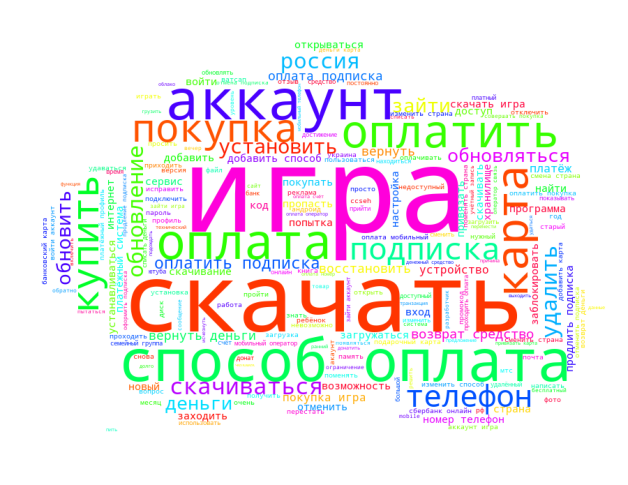

In [ ]:
url = "https://www.pinclipart.com/picdir/middle/519-5194083_cloud-clipart.png"
response = requests.get(url)
cloud_mask = np.array(Image.open(BytesIO(response.content)))
cld = ' '.join(all_words)
cloud = WordCloud(background_color="white", max_words=200, mask=cloud_mask, colormap="hsv").generate(cld)

plt.figure(figsize=(11,11))
plt.imshow(cloud)
plt.axis('off');

На данном облаке представлены как униграммы, так и биграммы. Среди биграмм выделяются "способ оплата", "оплатить подписка", "скачать игра"

In [ ]:
words = dict(Counter(all_words))
print(len(words))

6423


Для получения облака только из униграмм добавим все слова в словарь и посчитаем количество уникальных слов

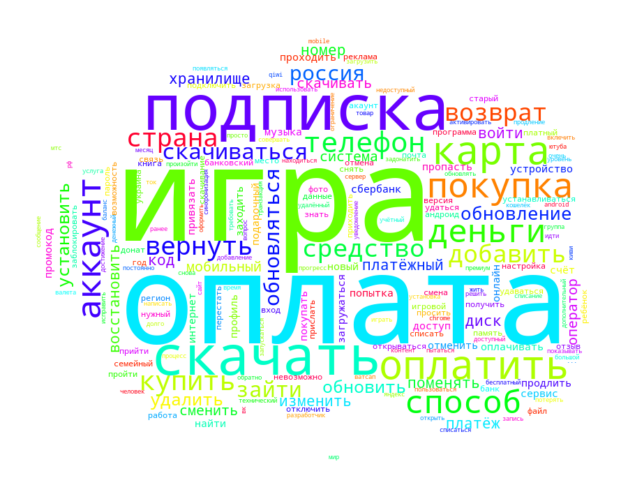

In [ ]:
url = "https://www.pinclipart.com/picdir/middle/519-5194083_cloud-clipart.png"
response = requests.get(url)
cloud_mask = np.array(Image.open(BytesIO(response.content)))

# складываем облако слов в маску
wc = WordCloud(background_color="white", max_words=200, mask=cloud_mask, colormap="hsv")
wc.generate_from_frequencies(words)

# визуализируем
plt.figure(figsize=(11, 11))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off");

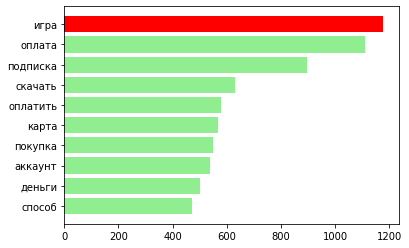

In [ ]:
res = pd.DataFrame(all_words, columns=["terms"])
vis = pd.DataFrame(res.terms.value_counts()).sort_values(by="terms", ascending=False)[:10].sort_values(by="terms")
colors = ["lightgreen" for _ in range(9)]+["red"]
plt.barh(y=vis.index, width=vis.terms, color=colors)
plt.show()

Частотный анализ показал, что самым распространенным в обращениях является слово "игра", также слова, связанные с оплатой ("оплата", "оплатить", "деньги", "способ", "карта", "покупка") и некоторые другие.

# Анализ тональности документов корпуса

In [ ]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [ ]:
messages = df.text.tolist()

results = model.predict(messages, k=1)
sent = []

for message, sentiment in zip(messages, results):
    sent.append(list(sentiment.keys())[0])

df["sentiment"] = sent
df.tail()

,text,tokens,sentiment
9995,Я задонил в стандофф деньги списали товар не ...,"[задонил, стандофф, деньги, списать, товар, по...",negative
9996,был запрошен возврат средств за покупку игры....,"[запросить, возврат, средство, покупка, игра, ...",neutral
9997,Я не могу привязать карту и выдаёт ошибку OR-...,"[привязать, карта, or-ccseh-16]",neutral
9998,Нет доступа к приложению.,[доступ],neutral
9999,"Возможно, этот браузер или приложение небезоп...","[браузер, небезопасный, попробовать, сменить, ...",neutral


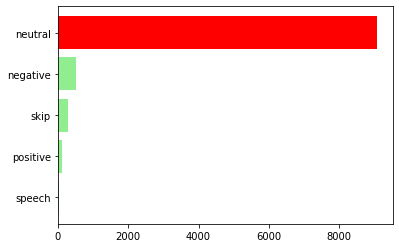

In [ ]:
vis = pd.DataFrame(df.sentiment.value_counts()).sort_values(by="sentiment")

colors = ["lightgreen" for _ in range(4)]+["red"]
plt.barh(y=vis.index, width=vis.sentiment, color=colors)
plt.show()

Большинство слов в анализе тональности документов было отнесено к нейтральным. Так как чаще всего обращения на форуме связаны с какими-либо проблемами, негативных обращений гораздо больше, чем позитивных.

# Тематическое моделирование

In [ ]:
id2word = corpora.Dictionary(df.tokens.tolist())
texts = df.tokens.tolist()
corpus = [id2word.doc2bow(text) for text in texts]

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=20, step=1)

100%|██████████| 18/18 [01:46<00:00,  5.94s/it]


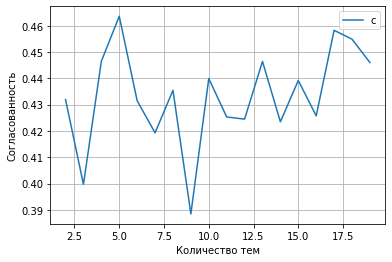

In [ ]:
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

In [ ]:
n_topics = 5

In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=n_topics)

In [ ]:
lda_model.print_topics()

[(0,
  '0.098*"оплата" + 0.060*"способ" + 0.028*"подписка" + 0.028*"добавить" + 0.017*"оператор" + 0.015*"карта" + 0.013*"мобильный" + 0.012*"изменить" + 0.012*"скачать" + 0.012*"оплатить"'),
 (1,
  '0.021*"средство" + 0.019*"возврат" + 0.015*"установить" + 0.013*"обновить" + 0.012*"телефон" + 0.011*"покупка" + 0.009*"подписка" + 0.009*"игра" + 0.009*"деньги" + 0.009*"войти"'),
 (2,
  '0.040*"скачать" + 0.036*"подписка" + 0.028*"скачиваться" + 0.025*"купить" + 0.022*"страна" + 0.021*"игра" + 0.015*"оплата" + 0.015*"телефон" + 0.011*"сменить" + 0.010*"код"'),
 (3,
  '0.042*"карта" + 0.041*"оплата" + 0.034*"оплатить" + 0.023*"игра" + 0.019*"деньги" + 0.016*"подписка" + 0.014*"вернуть" + 0.014*"обновление" + 0.013*"аккаунт" + 0.011*"россия"'),
 (4,
  '0.071*"игра" + 0.050*"покупка" + 0.032*"аккаунт" + 0.030*"деньги" + 0.020*"подписка" + 0.015*"возврат" + 0.015*"зайти" + 0.014*"средство" + 0.013*"вернуть" + 0.010*"скачать"')]

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.096588  0.065259       1        1  24.376760
3      0.054990  0.067368       2        1  20.591703
2      0.015470 -0.159031       3        1  19.167012
0      0.157069  0.029570       4        1  18.766926
1     -0.130941 -0.003165       5        1  17.097599, topic_info=        Term         Freq        Total Category  logprob  loglift
1     оплата  1136.000000  1136.000000  Default  30.0000  30.0000
12    способ   504.000000   504.000000  Default  29.0000  29.0000
84   покупка   535.000000   535.000000  Default  28.0000  28.0000
18      игра  1017.000000  1017.000000  Default  27.0000  27.0000
115    карта   498.000000   498.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
262  игровой    22.700146    68.493779   Topic5  -5.6108   0.6619
44    купить    32.358156   272.787600   Topic5  -5.2563  -0.3656
56   удалить    26.549521   172.605313   Topic5  -5.4541  -0.1058
23   скачать    27.033032   487.959090   Topic5  -5.4361  -1.1269
41   аккаунт    22.875056   442.064731   Topic5  -5.6031  -1.1952

[377 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3187      2  0.826385       14
2597      5  0.813547       26
646       5  0.855063  airline
2503      2  0.965581       at
375       4  0.884007     boom
...     ...       ...      ...
1081      1  0.868302     цена
485       3  0.109843     часы
485       5  0.878741     часы
1938      2  0.929984   читать
1783      2  0.861464   январь

[800 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2])

Мы выделили 5 тем, так как это количество соответствует оптимальному пику согласованности. Среди тем, которые нам удалось выявить, оказались:

1.   покупки в игровых аккаунтах
2.   оплата картой из России
3.   проблемы со скачиванием и загрузкой приложений
4.   просьбы добавить способ оплаты с мобильного счета
5.   требования вернуть средства











# Графы

In [ ]:
pairs = []
for doc in df.tokens.tolist():
  if doc:
    b = list((nltk.bigrams(doc)))
    if b:
      pairs.extend(b)
len(pairs)

26588

In [ ]:
pairs = [tuple(sorted(pair)) for pair in pairs]
word_pairs = dict(Counter(pairs))
print(len(word_pairs))

16961


In [ ]:
word_pairs = [(pair[0], pair[1], val) for pair, val in word_pairs.items() if val > 10]
G = nx.Graph()
edges = word_pairs
edges[:10], len(edges)

([('мобильный', 'оплата', 53),
  ('мобильный', 'телефон', 26),
  ('добавить', 'способ', 91),
  ('оплата', 'способ', 417),
  ('номер', 'оплата', 28),
  ('игра', 'покупать', 19),
  ('обновить', 'скачать', 26),
  ('смена', 'страна', 40),
  ('игра', 'играть', 11),
  ('аккаунт', 'вернуть', 12)],
 159)

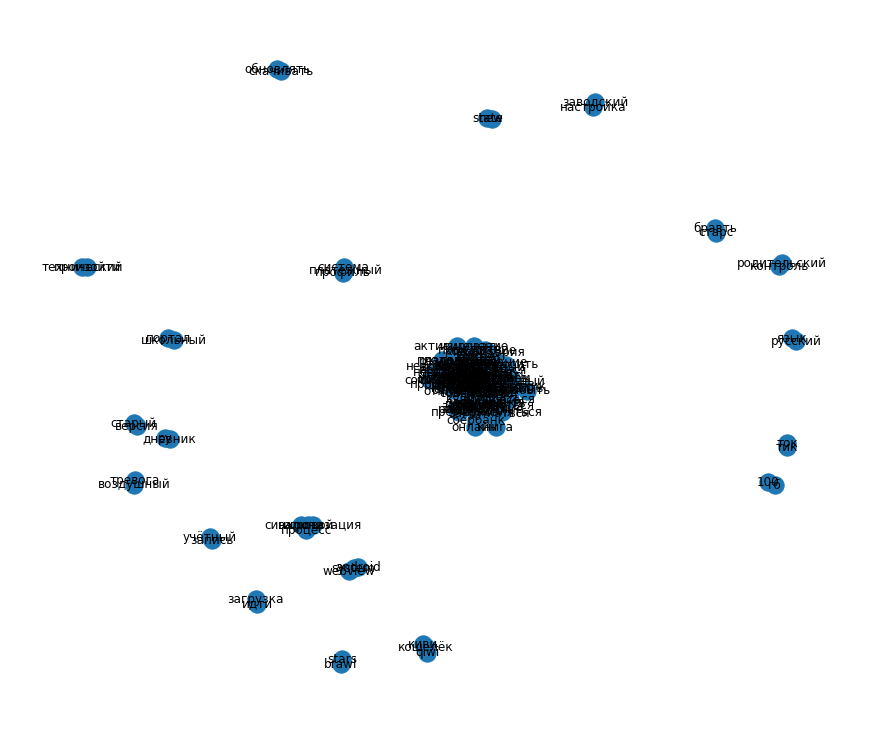

In [ ]:
plt.figure(figsize=(12,10))
G.add_weighted_edges_from(edges)
labels = nx.get_edge_attributes(G, "weight")
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

Граф получился нечитаемым, поэтому на следующем шаге мы удаляем все изолированные пары вершин

In [ ]:
remove = [node for node, degree in dict(G.degree()).items() if degree < 2]
G.remove_nodes_from(remove)
remove_edge = [pair for pair in G.edges() if pair[0] in remove and pair[1] in remove]
G.remove_edges_from(remove_edge)
remove = [node for node, degree in dict(G.degree()).items() if degree < 1]
G.remove_nodes_from(remove)
node_sizes = [deg*50 for node, deg in dict(G.degree()).items()]

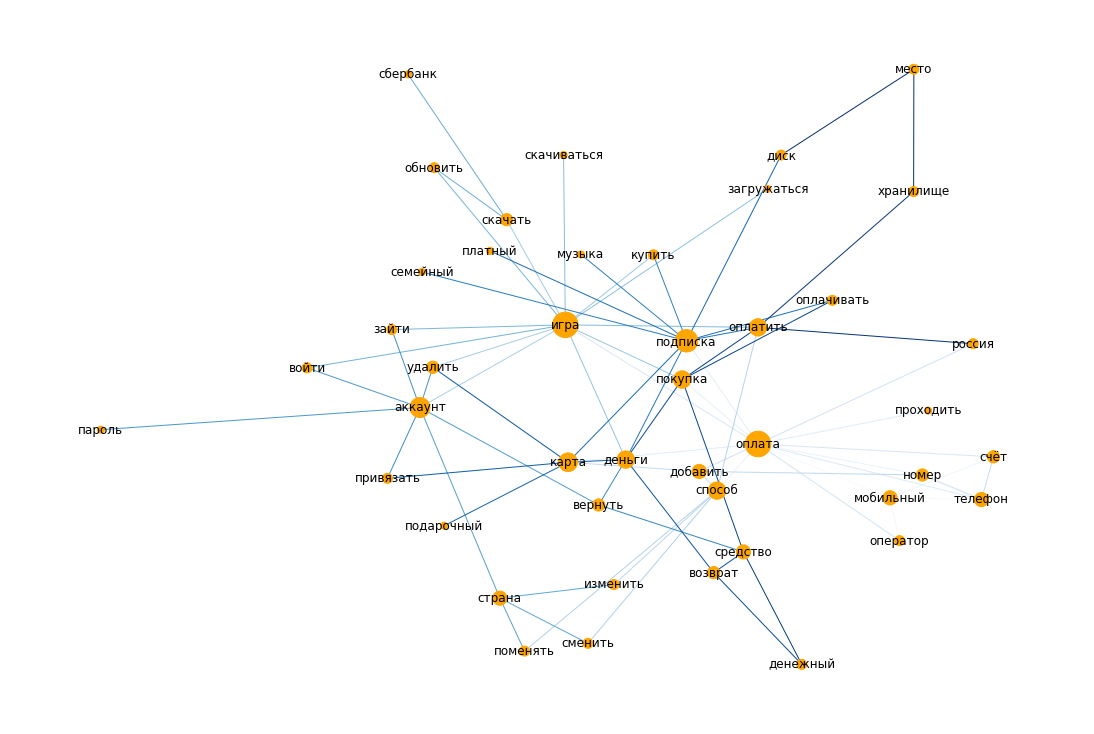

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.layout.spring_layout(G)
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw(G, pos, node_color='orange', node_size=node_sizes, edgelist=G.edges(), edge_color=range(len(G.edges())), width=1.0, with_labels=True, edge_cmap=plt.cm.Blues)
plt.show()

На данном графе уже различимы слова и связи между ними. Яркие ребра можно заметить между словами "оплатить Россия", "привязать карта", "оплатить покупка/подписка", "денежный средство"